In [110]:
# hydro code
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
import importlib
from numba import jit
import copy
%matplotlib inline

In [68]:
import upwind_scheme as uw
importlib.reload(uw)

<module 'upwind_scheme' from '/mnt/data/jeowen/notebooks/Slim_disc_external/upwind_scheme.py'>

In [3]:
### test hydro code loop

def full_boundary_update(bg,f,R0,h,cs,Sigma0):
    
    Sigma_boundary_update(bg,f,R0,Sigma0)
    velocity_boundary_update(bg,f,h,cs)
    
def Sigma_boundary_update(bg,f,R0,Sigma0):
    
    ### inner boundary
    f.Sigma_g[:bg.ii] = Sigma0*(R0/bg.R[:bg.ii])**2.
    
    if (f.Ndust > 0):
        f.Sigma_dust[:bg.ii,:] = 0.01 * np.outer(f.Sigma_g[:bg.ii],np.ones(f.Ndust)) # as no feedback just hardcode to 0.01 of gas at inner boundary
    
    
    ## outer boundary
    f.Sigma_g[bg.io+1:] = f.Sigma_g[bg.io]
    
    if (f.Ndust > 0):
        f.Sigma_dust[bg.io+1:,:] = f.Sigma_dust[bg.io,:]
        
        ### check_dust floor
        f.Sigma_dust[f.Sigma_dust < 1e-15] = 1e-15
    
    
    
def velocity_boundary_update(bg,f,h,cs):
    
    ### inner boundary
    f.uR[:bg.ii] = 0.
    f.uphi[:bg.ii] = np.sqrt((h/bg.R[:bg.ii])**2. - 7./2. * cs**2.)
    
    if (f.Ndust > 0):
        ## set gas and dust velocity equal in boundary
        f.uR_dust[:bg.ii,:] = 0.
        f.uphi_dust[:bg.ii,:] = np.outer(f.uphi[:bg.ii],np.ones(f.Ndust)) 
    
    ## outer boundary
    f.uR[bg.io+1:] = f.uR[bg.io] * (0.500000000001 + 0.5*np.sign(f.uR[bg.io]))
    f.uphi[bg.io+1:] = f.uphi[bg.io]
    
    if (f.Ndust > 0):
        f.uR_dust[bg.io+1:,:] = f.uR_dust[bg.io,:] * (0.500000000001 + 0.5*np.sign(f.uR_dust[bg.io,:]))
        f.uphi_dust[bg.io+1:,:] = f.uphi_dust[bg.io,:]
    
def temperature_update(bg,f,kappa,use_dust):
    
    mmw_c = 2.35 * 1.67e-24
    mmw_h = 1.3 * 1.67e-24
    kb = 1.38e-16
    # updates the temperature using a simple expression
    Thot = 150.
    Tcold = 100. * (bg.R/1.5e13)**(-0.5)
    Tcold [Tcold < 10.] = 10.
    
    if (use_dust):
            tau = get_tau(bg.dR,f.Sigma_dust[:,0],f.H,kappa,bg.ii,bg.io,bg.NR)
    else:
        tau = get_tau(bg.dR,f.Sigma_g,f.H,kappa,bg.ii,bg.io,bg.NR)
    
    cs_cold = np.sqrt(kb * Tcold/ mmw_c)
    cs_hot = np.sqrt(kb * Thot /mmw_h)
    
    cs_use = cs_cold * (1.-np.exp(-tau)) + cs_hot * np.exp(-tau)
    
    f.cs = np.copy(cs_use)
    
@jit(nopython=True)    
def get_tau(dRb,Sigma,H,cross_sec,ii,io,NR):
    
    tau = np.zeros(NR+4) 
    for i in range(io,ii-3,-1):
        
        tau[i] = tau[i+1] + dRb[i+1] * kappa * (Sigma[i+1]/H[i+1]+Sigma[i]/H[i+1]) * 0.5
        
    return tau
        
    

def single_update(agrd,bgrd,f,hbd,Sigma0,kappa_use,pure_alpha,nu_pl,use_dust_tau):
    
    if (f.Ndust > 0):
        # create momentum arrays to store fluxes for dust
        Sr_dust = np.zeros((bgrd.NR+5,f.Ndust))
        Sphi_dust = np.zeros((bgrd.NR+4,f.Ndust))
    
    # does a single update of the hydro
    
    # find time-step
    
    dt = uw.get_timestep(agrd.dR,f.uR,f.cs)
    
    ## update mid-plane pressure
    
    temperature_update(bgrd,f,kappa_use,use_dust_tau)
    uw.get_mid_plane_values(f)
    
    # source update
    ## gas
    f.uR, f.agr = uw.source_update(f.GM,agrd.R,bgrd.dR,agrd.g32,f.Pmid,f.uR,f.uphi,f.H,f.Sigma_g,dt,agrd.ii,agrd.io,agrd.NR)
    ## dust
    if (f.Ndust > 0):
        f.uR_dust,f.uphi_dust = uw.dust_source_update(f.GM,agrd.R,agrd.g32,f.uphi,f.uphi_dust,f.uR,f.agr,f.uR_dust,f.Omega_Ka,f.Omega_Kb,f.Sigma_g,f.sizes,f.rho_int,bgrd.ii,bgrd.io,bgrd.NR,f.Ndust,dt)
        f.uR_dust_diff =  uw.dust_diffusion(use_alpha,f.alpha,f.cs,f.Omega_Ka,nu_pl_index,f.Sc,f.Sigma_g,f.Sigma_dust,bgrd.dR,agrd.R,bgrd.R,bgrd.ii,bgrd.io,bgrd.NR,f.Ndust)

    
    ## disc viscosity update
    
    f.uphi = uw.disc_viscosity_update(pure_alpha,f.alpha,f.cs,f.Omega_Ka,f.uphi,agrd.R,bgrd.R,bgrd.dR,agrd.dvRT,f.Sigma_g,dt,agrd.ii,agrd.io,agrd.NR,nu_pl)

    ## full boundary update
    full_boundary_update(bgrd,f,agrd.R[agrd.ii],hbd,f.cs[0],Sigma0)
    
    ## tranport update
    ## gas 
    f.Sigma_g, Sr, Sphi = uw.transport_update(agrd.dR,agrd.dvR,bgrd.dR,bgrd.dvR,agrd.g32,bgrd.g32,f.Sigma_g,f.uR,f.uphi,dt,agrd.ii,agrd.io,agrd.NR)
    ## dust
    if (f.Ndust > 0.):
        for j in range(f.Ndust):
            f.Sigma_dust[:,j], Sr_dust[:,j],Sphi_dust[:,j] =  uw.transport_update(agrd.dR,agrd.dvR,bgrd.dR,bgrd.dvR,agrd.g32,bgrd.g32,f.Sigma_dust[:,j],f.uR_dust[:,j]+f.uR_dust_diff[:,j],f.uphi_dust[:,j],dt,agrd.ii,agrd.io,agrd.NR)
    
    ### Suface density boundary update
    Sigma_boundary_update(bgrd,f,agrd.R[agrd.ii],Sigma0)
    ## now update the velocities from the momentum fluxes
    f.uR, f.uphi = uw.momentum_to_velocity(Sr,Sphi,f.Sigma_g,bgrd.g32,bgrd.ii,bgrd.io,bgrd.NR)
    if (f.Ndust > 0.):
        for j in range(f.Ndust):
            f.uR_dust[:,j], f.uphi_dust[:,j] = uw.momentum_to_velocity(Sr_dust[:,j],Sphi_dust[:,j],f.Sigma_dust[:,j],bgrd.g32,bgrd.ii,bgrd.io,bgrd.NR)
    
    ### Velocity boundaries
    velocity_boundary_update(bgrd,f,hbd,f.cs[0])

    
    ## update done
    return dt
    
    

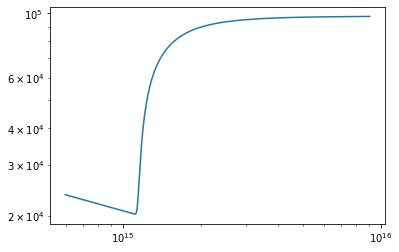

In [116]:
#### testing 
#agrd, bgrd, f = uw.build_grid(6e14,9e15,1000,25)

f = copy.deepcopy(f1Myr)

Sigma0 = 133. 
#f.Sigma_g = Sigma0*(agrd.R[2]/bgrd.R)**4.
f.Sigma_dust = np.outer(0.01 * f.Sigma_g,np.ones(f.Ndust))
f.sizes = np.logspace(-4.5,-1.75,f.Ndust)
f.Sc = np.ones(f.Ndust)
f.rho_int = np.zeros(f.Ndust) + 1.
f.GM = 6.67e-8*2e33
f.Omega_Kb = np.sqrt(f.GM/bgrd.R**3.)
f.Omega_Ka = np.sqrt(f.GM/agrd.R**3.)
f.alpha[:] = 1e-3
h = 1.0*np.sqrt(f.GM*bgrd.R[1])



# isothermal simulations
# f.cs = np.ones(np.size(f.cs))+1.e5

#f.cs = np.ones(np.size(f.cs))+1.e5 # guess sound speed to calculate H
#uw.get_mid_plane_values(f)
kappa = 15. 
use_dust_tau = False
temperature_update(bgrd,f,kappa,use_dust_tau)

plt.loglog(bgrd.R,f.cs)



f.uphi[:] = np.sqrt(f.GM/bgrd.R)

full_boundary_update(bgrd,f,agrd.R[agrd.ii],h,f.cs[0],Sigma0)

In [121]:
time = 0.

use_alpha = True
nu_pl_index = 1.5

counter = 0

for i in range(20000000):    
    
    dt = single_update(agrd,bgrd,f,h,Sigma0,kappa,use_alpha,nu_pl_index,use_dust_tau)
    
    if (i % 100000000 == 0):
        
        plt.figure()
        plt.loglog(bgrd.R,f.Sigma_g,'.')
        plt.loglog(bgrd.R,(agrd.R[agrd.ii]/bgrd.R)**(2.),'--')
        plt.loglog(bgrd.R,f.Sigma_dust[:,0])
        plt.savefig("fig%d.png" %counter)
        counter += 1
        plt.close()

        
    
    time += dt
    
    if (time > 0.09 * 1e6 * 31556926):
        break

print (time/31556926/1e3)

90.00046072141485


0.09000046072141486
[1.34084913 1.33360659        nan ...        nan        nan        nan]
[-4.5        -4.38541667 -4.27083333 -4.15625    -4.04166667 -3.92708333
 -3.8125     -3.69791667 -3.58333333 -3.46875    -3.35416667 -3.23958333
 -3.125      -3.01041667 -2.89583333 -2.78125    -2.66666667 -2.55208333
 -2.4375     -2.32291667 -2.20833333 -2.09375    -1.97916667 -1.86458333
 -1.75      ]


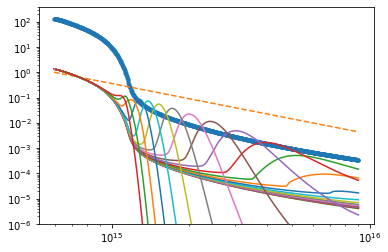

In [122]:
print (time/31556926/1e6)

plt.loglog(bgrd.R,f.Sigma_g,'.')
plt.loglog(bgrd.R,(agrd.R[agrd.ii]/bgrd.R)**(2.),'--')
#plt.loglog(bgrd.R,f.Sigma_dust[:,0])
#plt.loglog(bgrd.R,f.Sigma_dust[:,9])
plt.loglog(bgrd.R,f.Sigma_dust[:,:])
#plt.loglog(bgrd.R,f.Sigma_dust[:,29])

print (f.Sigma_dust[:,-3])
print(np.log10(f.sizes))

fbig = np.load('big_dust.npy',allow_pickle=True).item()

#plt.loglog(bgrd.R,fbig.Sigma_dust[:,-1])


plt.ylim((1e-6,400.))

f0p1Myr = copy.deepcopy(f)

Text(0.5, 1.0, '1 Myr')

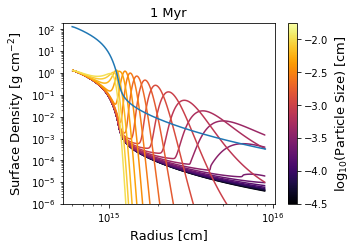

In [235]:
fig, ax = plt.subplots(figsize=(4*1.19,2.8*1.19))

R = np.array([bgrd.R for i in range(25)])
c = np.array(np.log10(f1Myr.sizes))

S = np.array([f1Myr.Sigma_dust[:,i] for i in range(25)])


lc = multiline(R,S,c,cmap='inferno')
c = plt.colorbar(lc)
plt.xscale('log')
plt.yscale('log')
plt.ylim((1e-6,200.))

plt.loglog(bgrd.R,f1Myr.Sigma_g)
plt.xlabel('Radius [cm]',fontsize=13)
plt.ylabel(r'Surface Density [g cm$^{-2}$]',fontsize=13)
c.set_label(r'$\log_{10}$(Particle Size) [cm]',fontsize=13)
plt.title('1 Myr',fontsize=13)
#plt.savefig('/home/jeowen/Dropbox/Apps/Overleaf/Dust_external_evap/dust1myr.pdf',bbox_inches='tight')

<Figure size 702x216 with 0 Axes>

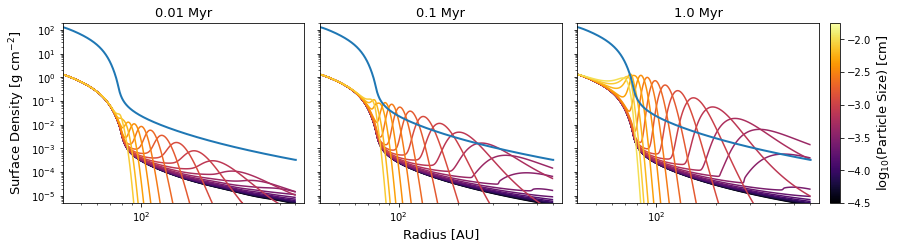

In [288]:
from mpl_toolkits.axes_grid1 import ImageGrid

au_cm = 1.496e13

# Set up figure and image grid
fig = plt.figure(figsize=(9.75, 3))

fig, ax = plt.subplots(1,3,figsize=(2.6*4*1.19,2.8*1.19),sharey=True,constrained_layout=True)

ii = 0
Fs = [f0p01Myr,f0p1Myr,f1Myr]
Title = ['0.01 Myr','0.1 Myr','1.0 Myr']

for axes in ax:
    R = np.array([bgrd.R/au_cm for i in range(25)])
    c = np.array(np.log10(Fs[0].sizes))

    S = np.array([Fs[ii].Sigma_dust[:,i] for i in range(25)])

    
    plt.ylim((5e-6,200.))
    axes.set_title(Title[ii],fontsize=13)

    axes.loglog(bgrd.R/au_cm,f1Myr.Sigma_g,lw=2)

    lc = multiline(R,S,c,ax = axes, cmap='inferno')
    
    
    
    ii +=1
    
c=plt.colorbar(lc,aspect=70)
c.set_label(r'$\log_{10}$(Particle Size) [cm]',fontsize=13)
ax[0].set_ylabel(r'Surface Density [g cm$^{-2}$]',fontsize=13)
ax[1].set_xlabel(r'Radius [AU]',fontsize=13)
ax[0].set_xlim((6e14/au_cm,1e16/au_cm))
ax[1].set_xlim((6e14/au_cm,1e16/au_cm))
ax[2].set_xlim((6e14/au_cm,1e16/au_cm))

plt.savefig('/home/jeowen/Dropbox/Apps/Overleaf/Dust_external_evap/dustevolve_au.pdf',bbox_inches='tight')    

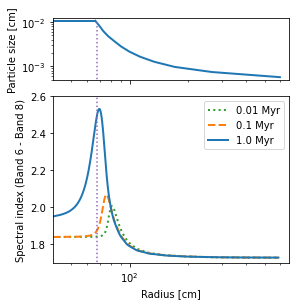

In [289]:
fig,(ax,ax2) = plt.subplots(2,1,sharex=True,figsize=(4,4.),constrained_layout=True,gridspec_kw={'height_ratios': [1,2.7]})

R_L = (f1Myr.uphi[-3]*bgrd.R[-3])**2./f1Myr.GM


### plot of radius at which particles become trapped as a function of radius

from scipy.interpolate import interp1d

rmax = np.zeros(f1Myr.Ndust)

for i in range(f1Myr.Ndust):
    
    get_r = interp1d(f1Myr.uR_dust[15:-2,i],np.log10(agrd.R[15:-2]),bounds_error=False)
    
    rmax[i] = 10.** get_r(0.7)
    
    
ax.loglog(rmax/au_cm,f1Myr.sizes,'C0',lw=2)
ax.loglog([6e14/au_cm,rmax[-3]/au_cm],[f1Myr.sizes[-3],f1Myr.sizes[-3]],'C0',lw=2)


###### Now calculate absorption opacity at 1 and 3 mm as a function of radius assuming p is some factor at the inner boundary

sizes_use = f1Myr.sizes[:-2]

kap_1mm_per_par = 10.**get_kappa_abs(np.log10(sizes_use),np.log10(0.07))[:,0] ## middle of Band 8
kap_3mm_per_par = 10.**get_kappa_abs(np.log10(sizes_use),np.log10(0.125))[:,0] ## middle of Band 6

p = 3.5

weights = (sizes_use/sizes_use)**(-p + 3.+1.) # plus 3 to convert to mass +1 for log spaced size bins

beta0p01Myr = np.zeros(np.size(bgrd.R))
beta0p1Myr = np.zeros(np.size(bgrd.R))
beta1Myr = np.zeros(np.size(bgrd.R))

for i in range(3,995):
    
    # get_opacity for all particle sizes at 1mm and 3mm
    
    Suse = np.copy(f0p01Myr.Sigma_dust[i,:-2])
    
    kap_1mm_cur_pos = np.nansum(weights*Suse*kap_1mm_per_par)/np.nansum(weights*Suse)
    kap_3mm_cur_pos = np.nansum(weights*Suse*kap_3mm_per_par)/np.nansum(weights*Suse)

    
    beta0p01Myr[i] = np.fabs((np.log(kap_3mm_cur_pos) - np.log(kap_1mm_cur_pos))/(np.log(1./0.07)-np.log(1./0.125)))
    
    Suse = np.copy(f0p1Myr.Sigma_dust[i,:-2])
    
    kap_1mm_cur_pos = np.nansum(weights*Suse*kap_1mm_per_par)/np.nansum(weights*Suse)
    kap_3mm_cur_pos = np.nansum(weights*Suse*kap_3mm_per_par)/np.nansum(weights*Suse)
    
    beta0p1Myr[i] = np.fabs((np.log(kap_3mm_cur_pos) - np.log(kap_1mm_cur_pos))/(np.log(1./0.07)-np.log(1./0.125)))
    
    Suse = np.copy(f1Myr.Sigma_dust[i,:-2])
    
    kap_1mm_cur_pos = np.sum(weights*Suse*kap_1mm_per_par)/np.sum(weights*Suse)
    kap_3mm_cur_pos = np.sum(weights*Suse*kap_3mm_per_par)/np.sum(weights*Suse)

    
    beta1Myr[i] = np.fabs((np.log(kap_3mm_cur_pos) - np.log(kap_1mm_cur_pos))/(np.log(1./0.07)-np.log(1./0.125)))
    

ax2.semilogx(bgrd.R[3:-10]/au_cm,beta0p01Myr[3:-10],'C2:',lw=2,label=r"0.01 Myr")
ax2.semilogx(bgrd.R[3:-10]/au_cm,beta0p1Myr[3:-10],'C1--',lw=2,label=r"0.1 Myr")
ax2.semilogx(bgrd.R[3:-10]/au_cm,beta1Myr[3:-10],'C0-',lw=2,label=r"1.0 Myr")
ax2.legend(loc=0)




ax2.set_xlabel('Radius [cm]')
ax2.set_ylabel('Spectral index (Band 6 - Band 8)')
ax.set_ylabel('Particle size [cm]')

ax2.plot([R_L/au_cm,R_L/au_cm],[1.6,2.6],'C4:')
ax.plot([R_L/au_cm,R_L/au_cm],[1e-4,1e-2],'C4:')

ax2.set_ylim((1.7,2.6))
ax.set_ylim((5e-4,1.2e-2))
#ax.set_ylim((1e-3,1e-2))
ax.set_xlim((6e14/au_cm,1e16/au_cm))
plt.savefig("/home/jeowen/Dropbox/Apps/Overleaf/Dust_external_evap/spectral_index_au.pdf",bbox_inches='tight')

In [191]:
### DSHARP opacities
import dsharp_opac as opacity
from scipy.interpolate import RectBivariateSpline


d      = np.load(opacity.get_datafile('default_opacities_smooth.npz'))
a      = d['a']
lam    = d['lam']
k_abs  = d['k_abs']
k_sca  = d['k_sca']



print (np.shape(k_sca))



#### create 2D in terpolant for opacities
get_kappa_abs = RectBivariateSpline(np.log10(a),np.log10(lam),np.log10(k_abs))

(200, 210)
[1.00000000e-05 1.06833667e-05 1.14134323e-05 1.21933882e-05
 1.30266437e-05 1.39168411e-05 1.48678717e-05 1.58838925e-05
 1.69693447e-05 1.81289731e-05 1.93678467e-05 2.06913808e-05
 2.21053608e-05 2.36159675e-05 2.52298039e-05 2.69539246e-05
 2.87958660e-05 3.07636795e-05 3.28659667e-05 3.51119173e-05
 3.75113487e-05 4.00747492e-05 4.28133240e-05 4.57390438e-05
 4.88646976e-05 5.22039481e-05 5.57713919e-05 5.95826229e-05
 6.36543007e-05 6.80042234e-05 7.26514053e-05 7.76161601e-05
 8.29201897e-05 8.85866790e-05 9.46403974e-05 1.01107807e-04
 1.08017177e-04 1.15398711e-04 1.23284674e-04 1.31709538e-04
 1.40710128e-04 1.50325789e-04 1.60598553e-04 1.71573322e-04
 1.83298071e-04 1.95824050e-04 2.09206013e-04 2.23502454e-04
 2.38775867e-04 2.55093014e-04 2.72525220e-04 2.91148685e-04
 3.11044815e-04 3.32300581e-04 3.55008895e-04 3.79269019e-04
 4.05186999e-04 4.32876128e-04 4.62457440e-04 4.94060239e-04
 5.27822669e-04 5.63892310e-04 6.02426831e-04 6.43594672e-04
 6.87575786e-

In [34]:
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [886]:
f.sizes[0] = 1e-5
f.rho_int[0] = 1.
vrd_new,vphid_new = uw.dust_source_update(f.GM,agrd.R,agrd.g32,f.uphi,f.uphi_dust,f.uR,f.agr,f.uR_dust,f.Omega_Ka,f.Omega_Kb,f.Sigma_g,f.sizes,f.rho_int,bgrd.ii,bgrd.io,bgrd.NR,1,dt)

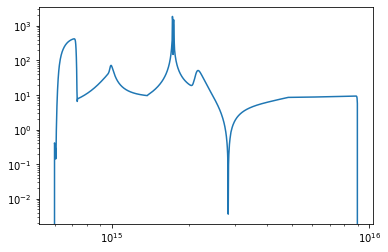

In [990]:
vr_dust_diff = uw.dust_diffusion(use_alpha,f.alpha,f.cs,f.Omega_Ka,nu_pl_index,np.array([1.]),f.Sigma_g,f.Sigma_dust,bgrd.dR,agrd.R,bgrd.R,bgrd.ii,bgrd.io,bgrd.NR,f.Ndust)

plt.figure()
plt.loglog(agrd.R,np.fabs(vr_dust_diff))

<ipython-input-1068-a121b9ae0a65>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bgrd.R/1.5e13,-1./(np.gradient((f.uphi),bgrd.R)/(f.uphi))/bgrd.R)


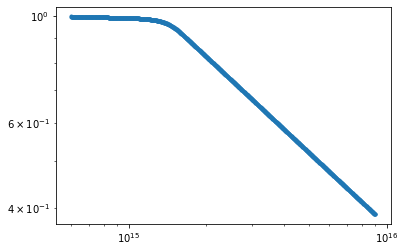

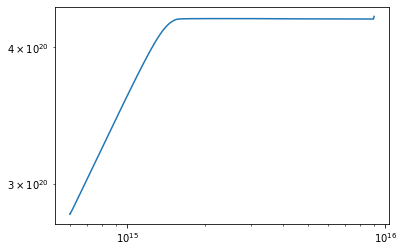

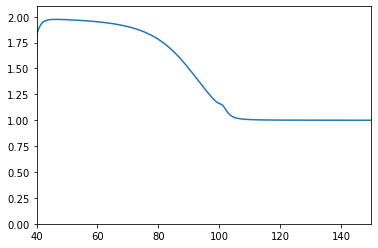

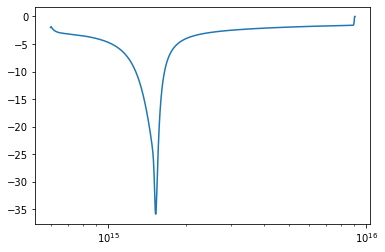

In [1068]:
plt.loglog(bgrd.R,f.uphi/np.sqrt(f.GM/bgrd.R),'.')

plt.figure()
plt.loglog(bgrd.R,f.uphi*bgrd.R)
plt.figure()

plt.plot(bgrd.R/1.5e13,-1./(np.gradient((f.uphi),bgrd.R)/(f.uphi))/bgrd.R)
plt.ylim((0.,2.1))
plt.xlim(40.,150.)

plt.figure()
plt.semilogx(bgrd.R,np.gradient(np.log(f.Sigma_g),np.log(bgrd.R)))

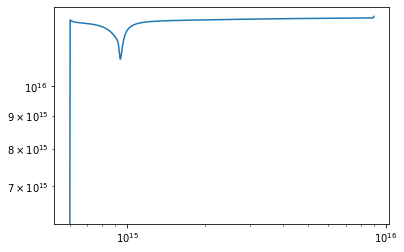

In [1002]:
plt.loglog(bgrd.R[1:-1],bgrd.R[1:-1]*f.Sigma_g[1:-1]*(f.uR[:-3]+f.uR[1:-2])/2.)

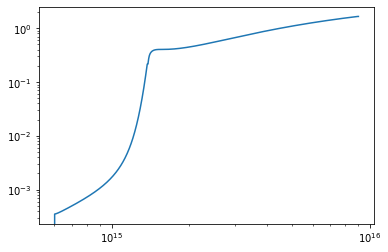

In [1025]:
plt.loglog(bgrd.R,f.uR[:-1]/f.cs)

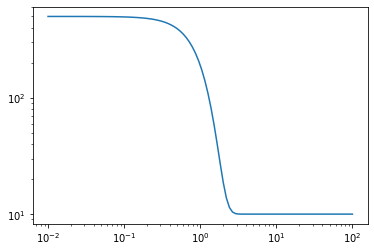

In [669]:
Tcold = 10.
Thot = 500.

tau =np.logspace(-2.,2,100)

plt.loglog(tau,Tcold*(1.-np.exp(-tau**2.))+Thot*np.exp(-tau**2.))

In [710]:
print (f.uR)

[0.00000000e+00 0.00000000e+00 2.35961992e+00 ... 2.81025848e+05
 2.81025848e+05 2.81025848e+05]


<ipython-input-169-0c36c9cd2c04>:18: RuntimeWarning: invalid value encountered in sqrt
  u_r_w_h = np.sqrt(-np.real(lambertw(-f_r_w_h[agrd.R<Rs_w_h],0)))


Text(0, 0.5, '$\\partial\\log v_\\phi/\\partial\\log R$')

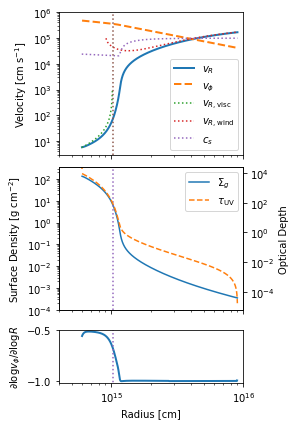

In [169]:
## fancy plot for paper

fig,(ax,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(4,5.8),constrained_layout=True,gridspec_kw={'height_ratios': [2.7,2.7,1]})


Rs0 = 2./5.*f.GM/f.cs[-1]**2.
huse = f.uphi[-3]*bgrd.R[-3]
R_L = huse**2./f.GM

## viscous solution
nu_use = f.alpha[0]*f.cs[0]**2./f.Omega_Kb[0] * (bgrd.R/bgrd.R[0])**nu_pl_index

u_visc = 1.5*bgrd.R*nu_use * f.Omega_Kb / (huse - f.Omega_Kb*bgrd.R**2.)
## wind solution
Rs_w_h = (Rs0 + np.sqrt(Rs0**2.-8./5.*(huse)**2./f.cs[-1]**2.))/2.
f_r_w_h = ((Rs_w_h/agrd.R)**5.*np.exp((2.*f.GM/f.cs[-1]**2.)*(1./Rs_w_h-1./agrd.R)-1.-huse**2./f.cs[-1]**2.*(1./Rs_w_h**2.-1./agrd.R**2.)))

u_r_w_h = np.sqrt(-np.real(lambertw(-f_r_w_h[agrd.R<Rs_w_h],0)))
u_r_w_h = np.append(u_r_w_h,np.sqrt(-np.real(lambertw(-f_r_w_h[agrd.R>Rs_w_h],-1)))) * f.cs[-1]

ax.loglog(agrd.R[2:-2],np.fabs(f.uR[2:-2]),label=r'$v_R$',lw=2)
ax.loglog(bgrd.R[2:-2],f.uphi[2:-2],'--',label=r'$v_\phi$',lw=2)
ax.loglog(bgrd.R[:np.argmax(u_visc)],u_visc[:np.argmax(u_visc)],':',label=r'$v_{R,{\rm visc}}$')
ax.loglog(agrd.R[np.nanargmax(u_r_w_h[:300]):],u_r_w_h[np.nanargmax(u_r_w_h[:300]):],':',label=r'$v_{R,{\rm wind}}$')

ax.plot(bgrd.R,f.cs,':',label=r'$c_s$')
 
ax.legend(loc=0)
    
ax.plot([R_L,R_L],[3.,1e6],':')

ax2.loglog(bgrd.R[2:-2],f.Sigma_g[2:-2],label=r'$\Sigma_g$')
ax2.set_ylim((1e-4,350.))
ax2.plot([6e14,6e14],[300,400],'C1--',label=r'$\tau_{\rm UV}$')

ax2.legend(loc=0)
ax2a=ax2.twinx()


ax2a.loglog(bgrd.R[2:-2],get_tau(bgrd.dR,f.Sigma_g,f.H,kappa,bgrd.ii,bgrd.io,bgrd.NR)[2:-2],'C1--')
ax2a.set_ylabel('Optical Depth')
ax2.plot([R_L,R_L],[1e-4,1000.],':C4')

ax2.set_ylabel(r'Surface Density [g cm$^{-2}$]')

ax.set_ylim((3.,1e6))
ax.set_xlim((4e14,1.e16))
ax.set_ylabel(r'Velocity [cm s$^{-1}$]')
ax3.set_xlabel(r'Radius [cm]')
    
#secy = ax.secondary_yaxis('right',functions=(dim_vel,inv_dim_vel))
#secy.set_ylabel('Mach Number')
#secx = ax.secondary_xaxis('top',functions=(dim_rad,inv_dim_rad))
#secx.set_xlabel(r'Radius [$R_{s0}$]')

pl = np.gradient(np.log(f.uphi),np.log(bgrd.R))

ax3.semilogx(bgrd.R[2:-4],pl[2:-4],lw=2)
ax3.plot([R_L,R_L],[-2.,0.],':C4')
ax3.set_ylim((-1.02,-0.498))
ax3.set_ylabel(r'$\partial\log v_\phi/\partial\log R$')

#plt.savefig('/home/jeowen/Dropbox/Apps/Overleaf/Dust_external_evap/Non_isothermal_alpha1e-3_2.pdf',bbox_inches='tight')

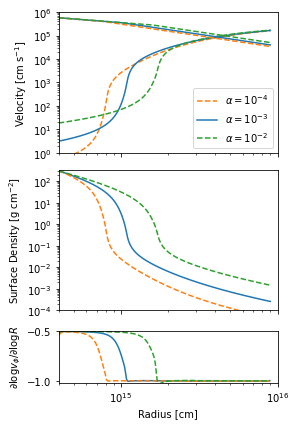

In [47]:
### Figure with varying the opacity
## fancy plot for paper

fig,(ax,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(4,5.8),constrained_layout=True,gridspec_kw={'height_ratios': [2.7,2.7,1]})


Rs0 = 2./5.*f.GM/f.cs[-1]**2.
huse = f.uphi[-3]*bgrd.R[-3]
R_L = huse**2./f.GM

f_la = np.load('noniso_3e-5_smooth_nom_kappa.npy', allow_pickle=True).item()
f_ha = np.load('noniso_1e-2_smooth_nom_kappa.npy', allow_pickle=True).item()


ax.loglog(agrd.R[2:-2],np.fabs(f_la.uR[2:-2]),'C1--',label=r'$\alpha=10^{-4}$')
ax.loglog(agrd.R[2:-2],np.fabs(f.uR[2:-2]),'C0-',label=r'$\alpha=10^{-3}$')
ax.loglog(agrd.R[2:-2],np.fabs(f_ha.uR[2:-2]),'C2--',label=r'$\alpha=10^{-2}$')
ax.legend(loc=0)
ax.loglog(bgrd.R[2:-2],f.uphi[2:-2],'C0-')
ax.loglog(bgrd.R[2:-2],f_la.uphi[2:-2],'C1--')
ax.loglog(bgrd.R[2:-2],f_ha.uphi[2:-2],'C2--')



ax2.loglog(bgrd.R[2:-2],f.Sigma_g[2:-2],'C0-')
ax2.loglog(bgrd.R[2:-2],f_la.Sigma_g[2:-2],'C1--')
ax2.loglog(bgrd.R[2:-2],f_ha.Sigma_g[2:-2],'C2--')


ax2.set_ylim((1e-4,350.))

#ax2.legend(loc=0)


ax2.set_ylabel(r'Surface Density [g cm$^{-2}$]')

ax.set_ylim((1.,1e6))
ax.set_xlim((4e14,1.e16))
ax.set_ylabel(r'Velocity [cm s$^{-1}$]')
ax3.set_xlabel(r'Radius [cm]')
    
#secy = ax.secondary_yaxis('right',functions=(dim_vel,inv_dim_vel))
#secy.set_ylabel('Mach Number')
#secx = ax.secondary_xaxis('top',functions=(dim_rad,inv_dim_rad))
#secx.set_xlabel(r'Radius [$R_{s0}$]')

pl = np.gradient(np.log(f.uphi),np.log(bgrd.R))

ax3.semilogx(bgrd.R[2:-4],pl[2:-4],'C0-')

pl = np.gradient(np.log(f_la.uphi),np.log(bgrd.R))

ax3.semilogx(bgrd.R[2:-4],pl[2:-4],'C1--')

pl = np.gradient(np.log(f_ha.uphi),np.log(bgrd.R))

ax3.semilogx(bgrd.R[2:-11],pl[2:-11],'C2--')




ax3.set_ylim((-1.02,-0.498))
ax3.set_ylabel(r'$\partial\log v_\phi/\partial\log R$')


plt.savefig('/home/jeowen/Dropbox/Apps/Overleaf/Dust_external_evap/Non_isothermal_vary_alpha.pdf',bbox_inches='tight')



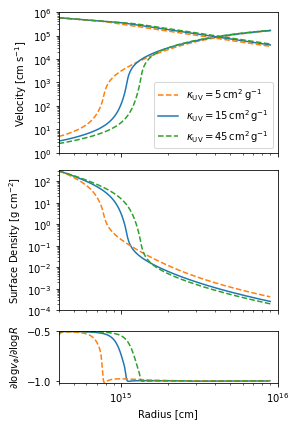

In [48]:
### Figure with varying the opacity
## fancy plot for paper

fig,(ax,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(4,5.8),constrained_layout=True,gridspec_kw={'height_ratios': [2.7,2.7,1]})


Rs0 = 2./5.*f.GM/f.cs[-1]**2.
huse = f.uphi[-3]*bgrd.R[-3]
R_L = huse**2./f.GM

f_lk = np.load('noniso_1e-3_smooth_low_kappa.npy', allow_pickle=True).item()
f_hk = np.load('noniso_1e-3_smooth_high_kappa.npy', allow_pickle=True).item()
agrd_lk = np.load('low_kappa_agrid.npy',allow_pickle=True).item()
bgrd_lk = np.load('low_kappa_bgrid.npy',allow_pickle=True).item()



ax.loglog(agrd_lk.R[2:-2],np.fabs(f_lk.uR[2:-2]),'C1--',label=r'$\kappa_{\rm UV}=5\,$cm$^2\,$g$^{-1}$')
ax.loglog(agrd.R[2:-2],np.fabs(f.uR[2:-2]),'C0-',label=r'$\kappa_{\rm UV}=15\,$cm$^2\,$g$^{-1}$')
ax.loglog(agrd.R[2:-2],np.fabs(f_hk.uR[2:-2]),'C2--',label=r'$\kappa_{\rm UV}=45\,$cm$^2\,$g$^{-1}$')
ax.legend(loc=0)
ax.loglog(bgrd.R[2:-2],f.uphi[2:-2],'C0-')
ax.loglog(bgrd_lk.R[2:-2],f_lk.uphi[2:-2],'C1--')
ax.loglog(bgrd.R[2:-2],f_hk.uphi[2:-2],'C2--')



ax2.loglog(bgrd.R[2:-2],f.Sigma_g[2:-2],'C0-')
ax2.loglog(bgrd_lk.R[2:-2],f_lk.Sigma_g[2:-2],'C1--')
ax2.loglog(bgrd.R[2:-2],f_hk.Sigma_g[2:-2],'C2--')


ax2.set_ylim((1e-4,350.))

#ax2.legend(loc=0)


ax2.set_ylabel(r'Surface Density [g cm$^{-2}$]')

ax.set_ylim((1.,1e6))
ax.set_xlim((4e14,1.e16))
ax.set_ylabel(r'Velocity [cm s$^{-1}$]')
ax3.set_xlabel(r'Radius [cm]')
    
#secy = ax.secondary_yaxis('right',functions=(dim_vel,inv_dim_vel))
#secy.set_ylabel('Mach Number')
#secx = ax.secondary_xaxis('top',functions=(dim_rad,inv_dim_rad))
#secx.set_xlabel(r'Radius [$R_{s0}$]')

pl = np.gradient(np.log(f.uphi),np.log(bgrd.R))

ax3.semilogx(bgrd.R[2:-4],pl[2:-4],'C0-')

pl = np.gradient(np.log(f_lk.uphi),np.log(bgrd_lk.R))

ax3.semilogx(bgrd_lk.R[2:-4],pl[2:-4],'C1--')

pl = np.gradient(np.log(f_hk.uphi),np.log(bgrd.R))

ax3.semilogx(bgrd.R[2:-11],pl[2:-11],'C2--')




ax3.set_ylim((-1.02,-0.498))
ax3.set_ylabel(r'$\partial\log v_\phi/\partial\log R$')


plt.savefig('/home/jeowen/Dropbox/Apps/Overleaf/Dust_external_evap/Non_isothermal_vary_kappa.pdf',bbox_inches='tight')




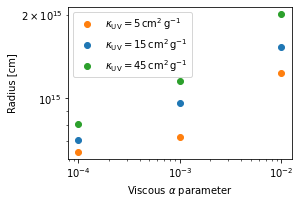

In [57]:
## Figure of launch radius vs alpha for nine models

fig, ax = plt.subplots(figsize=(4,2.8))





### high alpha

ha_lk = np.load("noniso_1e-2_smooth_low_kappa.npy",allow_pickle=True).item()
huse = ha_lk.uphi[-3]*bgrd.R[-3]
Rl_ha_lk = huse**2./f.GM

ha_nk = np.load("noniso_1e-2_smooth_nom_kappa.npy",allow_pickle=True).item()
huse = ha_nk.uphi[-3]*bgrd.R[-3]
Rl_ha_nk = huse**2./f.GM

ha_hk = np.load("noniso_1e-2_smooth_high_kappa.npy",allow_pickle=True).item()
huse = ha_hk.uphi[-3]*bgrd.R[-3]
Rl_ha_hk = huse**2./f.GM


plt.loglog(1e-2,Rl_ha_lk,'C1o',label=r'$\kappa_{\rm UV}=5\,$cm$^2\,$g$^{-1}$')
plt.plot(1e-2,Rl_ha_nk,'C0o',label=r'$\kappa_{\rm UV}=15\,$cm$^2\,$g$^{-1}$')
plt.plot(1e-2,Rl_ha_hk,'C2o',label=r'$\kappa_{\rm UV}=45\,$cm$^2\,$g$^{-1}$')
plt.legend(loc=0)
### nominal alpha

na_lk = np.load("noniso_1e-3_smooth_low_kappa.npy",allow_pickle=True).item()
huse = na_lk.uphi[-3]*bgrd.R[-3]
Rl_na_lk = huse**2./f.GM

na_nk = np.load("noniso_1e-3_smooth_nom_kappa.npy",allow_pickle=True).item()
huse = na_nk.uphi[-3]*bgrd.R[-3]
Rl_na_nk = huse**2./f.GM

na_hk = np.load("noniso_1e-3_smooth_high_kappa.npy",allow_pickle=True).item()
huse = na_hk.uphi[-3]*bgrd.R[-3]
Rl_na_hk = huse**2./f.GM


plt.plot(1e-3,Rl_na_lk,'C1o',label=r'$\kappa_{\rm UV}=5\,$cm$^2\,$g$^{-1}$')
plt.plot(1e-3,Rl_na_nk,'C0o',label=r'$\kappa_{\rm UV}=15\,$cm$^2\,$g$^{-1}$')
plt.plot(1e-3,Rl_na_hk,'C2o',label=r'$\kappa_{\rm UV}=45\,$cm$^2\,$g$^{-1}$')
### low alpha

la_lk = np.load("noniso_3e-5_smooth_low_kappa.npy",allow_pickle=True).item()
huse = la_lk.uphi[-3]*bgrd.R[-3]
Rl_la_lk = huse**2./f.GM

la_nk = np.load("noniso_3e-5_smooth_nom_kappa.npy",allow_pickle=True).item()
huse = la_nk.uphi[-3]*bgrd.R[-3]
Rl_la_nk = huse**2./f.GM

la_hk = np.load("noniso_3e-5_smooth_high_kappa.npy",allow_pickle=True).item()
huse = la_hk.uphi[-3]*bgrd.R[-3]
Rl_la_hk = huse**2./f.GM


plt.plot(1e-4,Rl_la_lk,'C1o',label=r'$\kappa_{\rm UV}=5\,$cm$^2\,$g$^{-1}$')
plt.plot(1e-4,Rl_la_nk,'C0o',label=r'$\kappa_{\rm UV}=15\,$cm$^2\,$g$^{-1}$')
plt.plot(1e-4,Rl_la_hk,'C2o',label=r'$\kappa_{\rm UV}=45\,$cm$^2\,$g$^{-1}$')


ax.set_ylabel('Radius [cm]')
ax.set_xlabel(r'Viscous $\alpha$ parameter')

plt.savefig('/home/jeowen/Dropbox/Apps/Overleaf/Dust_external_evap/launchvsalpha_noniso.pdf',bbox_inches='tight')


#plt.loglog(alpha_grid,rsol)
Rs = 2./5.*f.GM/(f.cs[-1])**2.
alpha_grid = np.logspace(-5,-1.,100)
#plt.semilogx(alpha_grid,-1./np.log(0.069*alpha_grid)*Rs, lw=2, label=r'Approximate Solution')


